# Mark Galperin - HW7
# Due November 18, 2020

*Please note that a **single** PDF file will be the only document that you turn in, which will include your answers to the problems with corresponding derivations and any code used to complete the problems. When including the code, please make sure you also include **code outputs**, and you don't need to include example code. Problems and deliverables that should be included with your submission are shown in **bold**.*

*This Juputer Notebook file serves as a template for you to start homework, since we recommend to finish the homework using Jupyter Notebook. You can start with this notebook file with your local Jupyter environment, or upload it to Google Colab. You can include all the code and other deliverables in this notebook Jupyter Notebook supports $\LaTeX$ for math equations, and you can export the whole notebook as a PDF file. But this is not the only option, if you are more comfortable with other ways, feel free to do so, as long as you can submit the homework in a single PDF file.*

***

In [1]:
# Update Sympy
#!pip install --upgrade sympy

In [2]:
import sympy as sym 
from sympy.abc import t
print(sym.__version__)

1.6.2


In [3]:
#other imports...
from sympy import Function, Matrix, Eq
import numpy as np
import matplotlib.pyplot as plt

## Problem 1 (20pts)

Show that if $R\in SO(n)$, then the matrix $A=\frac{d}{dt}(R)R^{-1}$ is skew symmetric.
    
**Turn in: A scanned (or photograph from your phone or webcam) copy of your hand written solution. Or you can use \LaTeX.**

See scan

## Problem 2 (20pts)

Show that $\underline{\widehat{\omega}}\,\underline{r}_b= -\underline{\widehat{r}}_b\, \underline{\omega}$. 
    
**Turn in: A scanned (or photograph from your phone or webcam) copy of your hand written solution. Or you can use \LaTeX.**

See scan

In [4]:
from IPython.core.display import HTML
display(HTML("<table><tr><td><img src='https://github.com/MuchenSun/ME314pngs/raw/master/biped_simplified.jpg' width=700' height='350'></table>"))

## Problem 3 (60pts)

As shown in the image, consider one is doing split. To simplify the model, we ignore the upper body and assume the knees can not bend --- which means we only need four variables $q=[x, y, \theta_1, \theta_2]$ to configure the system. $x$ and $y$ are the position of the intersection point of the two legs, $\theta_1$ and $\theta_2$ are the angles between the legs and the green vertical dash line. The feet are constrained on the ground, and there is no friction between the feet and the ground. 
    
Each leg is a rigid body with length $L=1$, width $W=0.2$, mass $m=1$, and rotational inertia $J=1$ (assuming the center of mass is at the center of geometry). Moreover, there are two torques applied on $\theta_1$ and $\theta_2$ to control the legs to track a desired trajectory:
$$
\begin{aligned}
\theta_1^d(t) & = \frac{\pi}{20} + \frac{\pi}{3} \sin^2(\frac{t}{2}) \\
\theta_2^d(t) & =-\frac{\pi}{20} - \frac{\pi}{3} \sin^2(\frac{t}{2})
\end{aligned}
$$ and the torques are:
$$
\begin{aligned}
F_{\theta_1 }& = -k_1(\theta_1-\theta_1^d)\\
F_{\theta_2} & = -k_1(\theta_2-\theta_2^d)
\end{aligned}
$$ In this problem we use $k_1=20$. 

Given the model description above, define the frames that you need (several example frames are shown in the image as well), simulate the motion of the biped for $t\in[0,10], dt=0.01$, with initial condition $q=[0, L_1\cos(\frac{\pi}{20}), \frac{\pi}{20}, -\frac{\pi}{20}]$. You will need to modify the animation function to display the leg as a rectangle, an example of the animation can be found at [https://youtu.be/w8XHYrEoWTc](https://youtu.be/w8XHYrEoWTc). 

*Hint 1: Even though this is a 2D system, in order to compute kinetic energy from both translation and rotation, you will need to model the system in 3D world --- the $z$ coordinate is always zero and the rotation is around $z$ axis (based on these facts, what should the SE(3) matrix and rotational inertia tensor look like?). This also means you need to represent transformation with SE(3) and the body velocity $\mathcal{V}_b\in\mathbb{R}^6$.*

*Hint 2: It could be helpful to define several helper functions for all the matrix operations you will need to use. For example, a function returns SE(3) matrices given rotation angle and 2D translation vector, functions for ''hat'' and ''unhat'' operations, a function for matrix inverse of SE(3) (which is definitely not the same as the SymPy matrix inverse function), and a function return the time derivative of SO(3) or SE(3).*

*Hint 3: In this problem the external force depends on time $t$, therefore in order to solve for the symbolic solution you need to substitute your configuration variables, which are defined as symbolic functions of time $t$ (such as $\theta_1(t)$ and $\frac{d}{dt}\theta_1(t)$), with dummy symbolic variables, and include $t$ as a separate symbol to be solved for. For the same reason (the dynamic now explicitly depends on time), you will need to do some tiny modifications on the ''integrate'' and ''simulate'' functions, a good reference can be found at [https://en.wikipedia.org/wiki/Runge-Kutta_methods](https://en.wikipedia.org/wiki/Runge-Kutta_methods).*

*Hint 4: Symbolically solving this system should be fast, but if you encountered some problem when solving the dynamics symbolically, an alternative method is to solve the system numerically --- substitute in the system state at each time step during simulation and solve for the numerical solution --- but based on my experience, this would cost more than one hour for 500 time steps, so it's not recommended.*

*Hint 5: The animation of this problem is similar to the one in last homework --- the coordinates of the vertices in the body frame are constant, you just need to transfer them back to the world frame using the the transformation matrices you already have in the simulation.*

*Hint 6: Be careful to consider the relationship between the frames and to not build in any implicit assumptions (such as assuming some variables are fixed).*

*Hint 7: The rotation, by convention, is assumed to follow the right hand rule, which means the z-axis is out of the screen and the positive rotation orientation is counter-clockwise. Make sure you follow a consistent set of positive directions for all the computation.*

*Hint 8: This problem is designed as a ''mini-project'', it could help you estimate the complexity of your final project, and you could adjust your proposal based on your experience with this problem.*

**Turn in: A copy of the code used to simulate and animate the system. Also, include a plot of the trajectory and upload a video of animation separately through Canvas. The video should be in ".mp4" format, you can use screen capture or record the screen directly with your phone.**

Matrix operation functions

In [5]:
def get_SE3_planar(R_th,p):
    """
    This function assembles planar homogenous transforms in SE(3) given either a rotation and a translation,
    or an R matrix and a translation.
    
    Takes...
        R_th: This input can be either a sympy matrix (at least 2x2) that is the rotation matrix for
            planar rotation about z, OR it can be a numerical value for the angle theta rotated about z
        
        p: a 3x1 (or 2x1) sympy matrix that is a homogenous coordinate vector for an x, y translation.
            p=0 is an acceptable input, shorthand for p = Matrix([0,0,0])
        
    Returns...
        g_SE3: a 3x3 sympy matrix that is a planar homogenous transform in SE(3)
    """
    
    #allowing p=0 as an input...
    if p==0:
        p = Matrix([0,0,0])
    
    #assembling the matrix...
    if type(R_th).__name__ == 'MutableDenseMatrix':
        #given R_th is a matrix in SE(2) at least... 
        g_SE3 = Matrix([[R_th[0,0], R_th[0,1], 0, p[0]],
                  [R_th[1,0], R_th[1,1], 0, p[1]],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    else:   
        #if R_or_th is a numerical value...
        g_SE3 = Matrix([[sym.cos(R_th), -sym.sin(R_th), 0, p[0]],
                      [sym.sin(R_th), sym.cos(R_th), 0, p[1]],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])
    
    return g_SE3

In [6]:
def hat(w):
    w_hat = Matrix([[0,    -w[2], w[1] ],
                    [w[2],   0,  -w[0] ],
                    [-w[1], w[0],   0  ]])
    return w_hat

In [7]:
def unhat(w_hat):
    return Matrix([w_hat[2,1],w_hat[0,2],w_hat[1,0]])

In [8]:
def g_inv(g):
    """
    This function calculates the inverse of a transformation g, in (planar) SE(3). 
    
    Dependencies:
        get_SE3_planar(th,p): Generates a planar homogenous transform in SE(3). Used for output.
    
    Takes...
        g: a 3x3 sympy matrix in SE(3)
        
    Returns...
        g_out: a 3x3 sympy matrix in SE(3) that is the "inverse" of g
    """
    #dissecting the input transformation g
    R = g[0:3,0:3]
    p = Matrix([g[0,3],g[1,3],1])
    
    RT = R.T
    p_inv = -RT*p
    
    return get_SE3_planar(RT,p_inv)

In [9]:
def g_dot(g,q_th):
    """
    This function gives the time-derivative of g
    g_dot = [R_dot p_dot
             0     1    ]
    ...where R_dot = Rw = wR, and w = [0 0 dq_th/dt], where q_th is the relevant config variable 
    
    TODO - more docstring
    """
    w = Matrix([0,0,1])
    
    #R_dot...
    R = g[0:3,0:3]
    R_dot = R*hat(w)
    
    #p_dot...
    p = g[0:3,3]
    p_dot = p.diff(t)
    
    #generating the transform...
    return get_SE3_planar(R_dot,p_dot)

In [10]:
def get_Vb(g,select='Vb'):
    
    #TODO: selection dictionary
    
    V4 = g_inv(g)*g_dot(g)
    w_hat = V4[0:3,0:3]
    v = V4[0:3,3]
    w = unhat(w_hat)
    Vb = v.col_join(w)
    return Vb

In [11]:
A = Matrix([[1,2,3],[4,5,6],[7,8,9]])
display(A)
B = A[0:2,0:2]
display(B)
C = Matrix([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
display(C)
D = C[0:3,0:3]
display(D)
E = C[0:3,3]
display(E)

Matrix([
[1, 2, 3],
[4, 5, 6],
[7, 8, 9]])

Matrix([
[1, 2],
[4, 5]])

Matrix([
[ 1,  2,  3,  4],
[ 5,  6,  7,  8],
[ 9, 10, 11, 12],
[13, 14, 15, 16]])

Matrix([
[1,  2,  3],
[5,  6,  7],
[9, 10, 11]])

Matrix([
[ 4],
[ 8],
[12]])

In [12]:
#testing out the SE(3) matrices...
ang = np.pi/6
ang_s = sym.pi/6
pee = Matrix([2,1,1])

#SE3
g0 = get_SE3_planar(ang,pee)
#inverse
g0_inv = g_inv(g0)
#derivative
g0_dot = g_dot(g0)

print('for the following inputs...')
display(Eq(sym.symbols('θ'),ang_s,evaluate=0))
display(Eq(sym.symbols('p'),pee,evaluate=0))
print('the SE(3) representation is:')
display(g0)
print('the \"inverse\" transformation is:')
display(g0_inv)
print('g-dot...')
display(g0_dot)
print('Vb-hat...')
V4 = g0_inv*g0_dot
display(V4)

for the following inputs...


Eq(θ, pi/6)

Eq(p, Matrix([
[2],
[1],
[1]]))

the SE(3) representation is:


Matrix([
[0.866025403784439,              -0.5, 0, 2],
[              0.5, 0.866025403784439, 0, 1],
[                0,                 0, 1, 0],
[                0,                 0, 0, 1]])

the "inverse" transformation is:


Matrix([
[0.866025403784439,               0.5, 0, -2.23205080756888],
[             -0.5, 0.866025403784439, 0, 0.133974596215561],
[                0,                 0, 1,                 0],
[                0,                 0, 0,                 1]])

g-dot...


Matrix([
[             -0.5, -0.866025403784439, 0, 0],
[0.866025403784439,               -0.5, 0, 0],
[                0,                  0, 1, 0],
[                0,                  0, 0, 1]])

Vb-hat...


Matrix([
[  0, -1.0, 0, -2.23205080756888],
[1.0,    0, 0, 0.133974596215561],
[  0,    0, 1,                 0],
[  0,    0, 0,                 1]])

In [13]:
#testing out the hat functions
a = Matrix([1,2,3])
a_s = sym.symbols(r'a')
a_hat_s = sym.symbols(r'a_{hat}')
a_unhat_s = sym.symbols(r'\mathrm{unhat}(a_{hat})')

a_hat = hat(a)
a_unhat = unhat(a_hat)

print('testing out the hat functions...')
display(Eq(a_s,a,evaluate=0))
display(Eq(a_hat_s,a_hat,evaluate=0))
display(Eq(a_unhat_s,a_unhat,evaluate=0))

testing out the hat functions...


Eq(a, Matrix([
[1],
[2],
[3]]))

Eq(a_{hat}, Matrix([
[ 0, -3,  2],
[ 3,  0, -1],
[-2,  1,  0]]))

Eq(\mathrm{unhat}(a_{hat}), Matrix([
[1],
[2],
[3]]))

**Symbols and Configuration**

In [14]:
#constants...
g = 9.8

#symbols...
L1 = sym.symbols('L_1')
L2 = sym.symbols('L_2')
W1 = sym.symbols('W_1')
W2 = sym.symbols('W_2')
m1 = sym.symbols('m_1')
m2 = sym.symbols('m_2')
J1 = sym.symbols('J_1')
J2 = sym.symbols('J_2')

#substitution dictionary...
SUBS = {L1:1,L2:1,
        W1:0.2,W2:0.2,
        m1:1,m2:1,
        J1:1,J2:1}

#time functions...
th1 = Function(r'θ_1')(t)
th2 = Function(r'θ_2')(t)
x = Function(r'x')(t)
y = Function(r'y')(t)

#configuration
q = Matrix([x,y,th1,th2])
qdot = q.diff(t)
qddot = qdot.diff(t)

print("configuration:")
display(q)

configuration:


Matrix([
[  x(t)],
[  y(t)],
[θ_1(t)],
[θ_2(t)]])

**Defining my Frames** <br>
Here I'll define my frames similarly to how they're defined in the figure

In [15]:
## TRANSFORMATIONS...
#display symbols...
gwA_sym = sym.symbols('g_{wA}')
gAB_sym = sym.symbols('g_{AB}')
gBD_sym = sym.symbols('g_{BD}')
gAC_sym = sym.symbols('g_{AC}')
gCE_sym = sym.symbols('g_{CE}')


#wA translates the origin of the world frame to {A}, at (x,y)
p_wA = Matrix([q[0],q[1],1])
gwA = get_SE3_planar(0,p_wA)

#AB is composed of a rotation of th1 about A, followed by a translation in -y in the new frame by L1/2.
#I'm composing them separately to be careful...
p_AB = Matrix([0,-L1/2,1])
gAB_R = get_SE3_planar(q[2],0)
gAB_p = get_SE3_planar(0,p_AB)
gAB = gAB_R*gAB_p

#BD translates {B} down by an additional L/2, with respect to the B frame.
p_BD = Matrix([0,-L1/2,1])
gBD = get_SE3_planar(0,p_BD)

#AC is composed of a rotation of th2 about A, given that theta2 is negative. This is followed 
#by a translation in -y in the new frame by L2/2.
#I'm composing them separately to be careful...
p_AC = Matrix([0,-L2/2,1])
gAC_R = get_SE3_planar(q[3],0)
gAC_p = get_SE3_planar(0,p_AC)
gAC = gAC_R*gAC_p

#CE translates {C} down by an additional L/2, with respect to the C frame.
p_CE = Matrix([0,-L2/2,1])
gCE = get_SE3_planar(0,p_CE)

#Display...
print('HOMOGENOUS TRANSFORM MATRICES IN SE(2):')
print('wA translates the origin of the world frame to {A}, at (x,y)')
display(Eq(gwA_sym,gwA,evaluate=False))
print('AB is composed of a rotation of th1 about A, followed by a translation in -y by L/2 in the new frame.')
display(Eq(gAB_sym,gAB,evaluate=False))
print('BD translates {B} down by an additional L/2, with respect to the B frame.')
display(Eq(gBD_sym,gBD,evaluate=False))
print('AC is composed of a rotation of -th2 about A, followed by a translation in -y in the new frame by L2/2.')
display(Eq(gAC_sym,gAC,evaluate=False))
print('CE translates {C} down by an additional L/2, with respect to the C frame.')
display(Eq(gCE_sym,gCE,evaluate=False))

HOMOGENOUS TRANSFORM MATRICES IN SE(2):
wA translates the origin of the world frame to {A}, at (x,y)


Eq(g_{wA}, Matrix([
[1, 0, 0, x(t)],
[0, 1, 0, y(t)],
[0, 0, 1,    0],
[0, 0, 0,    1]]))

AB is composed of a rotation of th1 about A, followed by a translation in -y by L/2 in the new frame.


Eq(g_{AB}, Matrix([
[cos(θ_1(t)), -sin(θ_1(t)), 0,  L_1*sin(θ_1(t))/2],
[sin(θ_1(t)),  cos(θ_1(t)), 0, -L_1*cos(θ_1(t))/2],
[          0,            0, 1,                  0],
[          0,            0, 0,                  1]]))

BD translates {B} down by an additional L/2, with respect to the B frame.


Eq(g_{BD}, Matrix([
[1, 0, 0,      0],
[0, 1, 0, -L_1/2],
[0, 0, 1,      0],
[0, 0, 0,      1]]))

AC is composed of a rotation of -th2 about A, followed by a translation in -y in the new frame by L2/2.


Eq(g_{AC}, Matrix([
[cos(θ_2(t)), -sin(θ_2(t)), 0,  L_2*sin(θ_2(t))/2],
[sin(θ_2(t)),  cos(θ_2(t)), 0, -L_2*cos(θ_2(t))/2],
[          0,            0, 1,                  0],
[          0,            0, 0,                  1]]))

CE translates {C} down by an additional L/2, with respect to the C frame.


Eq(g_{CE}, Matrix([
[1, 0, 0,      0],
[0, 1, 0, -L_2/2],
[0, 0, 1,      0],
[0, 0, 0,      1]]))

In [16]:
#Getting each frame in {w} coordinates...
gwB = gwA*gAB
gwC = gwA*gAC
gwD = gwB*gBD
gwE = gwC*gCE

#display...
gwB_sym = sym.symbols('g_{wB}')
gwC_sym = sym.symbols('g_{wC}')
gwD_sym = sym.symbols('g_{wD}')
gwE_sym = sym.symbols('g_{wE}')

print('Frame B')
display(Eq(gwB_sym,gwB,evaluate=False))
print('Frame C')
display(Eq(gwC_sym,gwC,evaluate=False))
print('Frame D')
display(Eq(gwD_sym,gwD,evaluate=False))
print('Frame E')
display(Eq(gwE_sym,gwE,evaluate=False))

Frame B


Eq(g_{wB}, Matrix([
[cos(θ_1(t)), -sin(θ_1(t)), 0,  L_1*sin(θ_1(t))/2 + x(t)],
[sin(θ_1(t)),  cos(θ_1(t)), 0, -L_1*cos(θ_1(t))/2 + y(t)],
[          0,            0, 1,                         0],
[          0,            0, 0,                         1]]))

Frame C


Eq(g_{wC}, Matrix([
[cos(θ_2(t)), -sin(θ_2(t)), 0,  L_2*sin(θ_2(t))/2 + x(t)],
[sin(θ_2(t)),  cos(θ_2(t)), 0, -L_2*cos(θ_2(t))/2 + y(t)],
[          0,            0, 1,                         0],
[          0,            0, 0,                         1]]))

Frame D


Eq(g_{wD}, Matrix([
[cos(θ_1(t)), -sin(θ_1(t)), 0,  L_1*sin(θ_1(t)) + x(t)],
[sin(θ_1(t)),  cos(θ_1(t)), 0, -L_1*cos(θ_1(t)) + y(t)],
[          0,            0, 1,                       0],
[          0,            0, 0,                       1]]))

Frame E


Eq(g_{wE}, Matrix([
[cos(θ_2(t)), -sin(θ_2(t)), 0,  L_2*sin(θ_2(t)) + x(t)],
[sin(θ_2(t)),  cos(θ_2(t)), 0, -L_2*cos(θ_2(t)) + y(t)],
[          0,            0, 1,                       0],
[          0,            0, 0,                       1]]))

In [17]:
#extracting the body positions for the two legs...
Ow = Matrix([0,0,0,1]) #world origin
rB = gwB*Ow
rC = gwC*Ow
#and constraint frames...
rD = gwD*Ow
rE = gwE*Ow

#display...
print('Position of c.o.m. 1 (Frame B):')
display(rB)
print('Position of c.o.m. 2 (Frame C):')
display(rC)
print('Position of constraint 1 (Frame D):')
display(rD)
print('Position of constraint 2 (Frame E):')
display(rE)

Position of c.o.m. 1 (Frame B):


Matrix([
[ L_1*sin(θ_1(t))/2 + x(t)],
[-L_1*cos(θ_1(t))/2 + y(t)],
[                        0],
[                        1]])

Position of c.o.m. 2 (Frame C):


Matrix([
[ L_2*sin(θ_2(t))/2 + x(t)],
[-L_2*cos(θ_2(t))/2 + y(t)],
[                        0],
[                        1]])

Position of constraint 1 (Frame D):


Matrix([
[ L_1*sin(θ_1(t)) + x(t)],
[-L_1*cos(θ_1(t)) + y(t)],
[                      0],
[                      1]])

Position of constraint 2 (Frame E):


Matrix([
[ L_2*sin(θ_2(t)) + x(t)],
[-L_2*cos(θ_2(t)) + y(t)],
[                      0],
[                      1]])

In [18]:
#Velocity terms for the two legs...
Vb_B = sym.simplify(get_Vb(gwB))
Vb_C = sym.simplify(get_Vb(gwC))

print('body velocity for B, C, respectively...')
display(Vb_B,Vb_C)

body velocity for B, C, respectively...


Matrix([
[L_1*Derivative(θ_1(t), t)/2 - x(t)*cos(θ_1(t)) - y(t)*sin(θ_1(t)) + sin(θ_1(t))*Derivative(y(t), t) + cos(θ_1(t))*Derivative(x(t), t)],
[                      L_1/2 + x(t)*sin(θ_1(t)) - y(t)*cos(θ_1(t)) - sin(θ_1(t))*Derivative(x(t), t) + cos(θ_1(t))*Derivative(y(t), t)],
[                                                                                                                                    0],
[                                                                                                                                    0],
[                                                                                                                                    0],
[                                                                                                                                    1]])

Matrix([
[L_2*Derivative(θ_2(t), t)/2 - x(t)*cos(θ_2(t)) - y(t)*sin(θ_2(t)) + sin(θ_2(t))*Derivative(y(t), t) + cos(θ_2(t))*Derivative(x(t), t)],
[                      L_2/2 + x(t)*sin(θ_2(t)) - y(t)*cos(θ_2(t)) - sin(θ_2(t))*Derivative(x(t), t) + cos(θ_2(t))*Derivative(y(t), t)],
[                                                                                                                                    0],
[                                                                                                                                    0],
[                                                                                                                                    0],
[                                                                                                                                    1]])

**Inertial Properties**

In [19]:
#defining inertial matrices in the body frames of each leg...
I1 = sym.diag(m1,m1,m1,1,1,J1)
I2 = sym.diag(m2,m2,m2,1,1,J2)

print('Inertia matrices for Leg 1 and Leg2, respectively:')
display(I1,I2)

Inertia matrices for Leg 1 and Leg2, respectively:


Matrix([
[m_1,   0,   0, 0, 0,   0],
[  0, m_1,   0, 0, 0,   0],
[  0,   0, m_1, 0, 0,   0],
[  0,   0,   0, 1, 0,   0],
[  0,   0,   0, 0, 1,   0],
[  0,   0,   0, 0, 0, J_1]])

Matrix([
[m_2,   0,   0, 0, 0,   0],
[  0, m_2,   0, 0, 0,   0],
[  0,   0, m_2, 0, 0,   0],
[  0,   0,   0, 1, 0,   0],
[  0,   0,   0, 0, 1,   0],
[  0,   0,   0, 0, 0, J_2]])

**Energy**

In [20]:
Vb_B.T*I1*Vb_B

Matrix([[J_1 + m_1*(L_1/2 + x(t)*sin(θ_1(t)) - y(t)*cos(θ_1(t)) - sin(θ_1(t))*Derivative(x(t), t) + cos(θ_1(t))*Derivative(y(t), t))**2 + m_1*(L_1*Derivative(θ_1(t), t)/2 - x(t)*cos(θ_1(t)) - y(t)*sin(θ_1(t)) + sin(θ_1(t))*Derivative(y(t), t) + cos(θ_1(t))*Derivative(x(t), t))**2]])

In [21]:
#Kinetic energy of each leg...
KE1 = (1/2)(Vb_B.T*I1*Vb_B)[0]
KE2 = (1/2)(Vb_C.T*I2*Vb_C)[0]

#Total Kinetic Energy...
KE = KE1+KE2

#Potential Energy... (I'm using "PE" now to not confuse myself with the body velocities)
PE = m1*g*rB[1] + m2*g*rC[1]

#Lagrangian
L = sym.simplify(KE - PE)

#Substitutions...
L_sub = sym.simplify(L.subs(SUBS))

#Display
KE1_s = sym.symbols(r'KE_1')
KE2_s = sym.symbols(r'KE_2')
PE_s = sym.symbols(r'PE')
print('The Kinetic Energies...')
display(Eq(KE1_s,KE1,evaluate=0))
display(Eq(KE2_s,KE2,evaluate=0))
print('Potential Energy...')
display(Eq(PE_s,PE,evaluate=0))
print('The Lagrangian')
display(L)
print('Substituted Lagrangian:')
display(L_sub)

The Kinetic Energies...


Eq(KE_1, J_1 + m_1*(L_1/2 + x(t)*sin(θ_1(t)) - y(t)*cos(θ_1(t)) - sin(θ_1(t))*Derivative(x(t), t) + cos(θ_1(t))*Derivative(y(t), t))**2 + m_1*(L_1*Derivative(θ_1(t), t)/2 - x(t)*cos(θ_1(t)) - y(t)*sin(θ_1(t)) + sin(θ_1(t))*Derivative(y(t), t) + cos(θ_1(t))*Derivative(x(t), t))**2)

Eq(KE_2, J_2 + m_2*(L_2/2 + x(t)*sin(θ_2(t)) - y(t)*cos(θ_2(t)) - sin(θ_2(t))*Derivative(x(t), t) + cos(θ_2(t))*Derivative(y(t), t))**2 + m_2*(L_2*Derivative(θ_2(t), t)/2 - x(t)*cos(θ_2(t)) - y(t)*sin(θ_2(t)) + sin(θ_2(t))*Derivative(y(t), t) + cos(θ_2(t))*Derivative(x(t), t))**2)

Potential Energy...


Eq(PE, 9.8*m_1*(-L_1*cos(θ_1(t))/2 + y(t)) + 9.8*m_2*(-L_2*cos(θ_2(t))/2 + y(t)))

The Lagrangian


J_1 + J_2 + 4.9*m_1*(L_1*cos(θ_1(t)) - 2*y(t)) + m_1*(L_1 + 2*x(t)*sin(θ_1(t)) - 2*y(t)*cos(θ_1(t)) - 2*sin(θ_1(t))*Derivative(x(t), t) + 2*cos(θ_1(t))*Derivative(y(t), t))**2/4 + m_1*(L_1*Derivative(θ_1(t), t) - 2*x(t)*cos(θ_1(t)) - 2*y(t)*sin(θ_1(t)) + 2*sin(θ_1(t))*Derivative(y(t), t) + 2*cos(θ_1(t))*Derivative(x(t), t))**2/4 + 4.9*m_2*(L_2*cos(θ_2(t)) - 2*y(t)) + m_2*(L_2 + 2*x(t)*sin(θ_2(t)) - 2*y(t)*cos(θ_2(t)) - 2*sin(θ_2(t))*Derivative(x(t), t) + 2*cos(θ_2(t))*Derivative(y(t), t))**2/4 + m_2*(L_2*Derivative(θ_2(t), t) - 2*x(t)*cos(θ_2(t)) - 2*y(t)*sin(θ_2(t)) + 2*sin(θ_2(t))*Derivative(y(t), t) + 2*cos(θ_2(t))*Derivative(x(t), t))**2/4

Substituted Lagrangian:


(2*x(t)*sin(θ_1(t)) - 2*y(t)*cos(θ_1(t)) - 2*sin(θ_1(t))*Derivative(x(t), t) + 2*cos(θ_1(t))*Derivative(y(t), t) + 1)**2/4 + (2*x(t)*sin(θ_2(t)) - 2*y(t)*cos(θ_2(t)) - 2*sin(θ_2(t))*Derivative(x(t), t) + 2*cos(θ_2(t))*Derivative(y(t), t) + 1)**2/4 + (-2*x(t)*cos(θ_1(t)) - 2*y(t)*sin(θ_1(t)) + 2*sin(θ_1(t))*Derivative(y(t), t) + 2*cos(θ_1(t))*Derivative(x(t), t) + Derivative(θ_1(t), t))**2/4 + (-2*x(t)*cos(θ_2(t)) - 2*y(t)*sin(θ_2(t)) + 2*sin(θ_2(t))*Derivative(y(t), t) + 2*cos(θ_2(t))*Derivative(x(t), t) + Derivative(θ_2(t), t))**2/4 - 19.6*y(t) + 4.9*cos(θ_1(t)) + 4.9*cos(θ_2(t)) + 2

**Force**

In [22]:
#Force Vector...
k1 = 20
#theta desired
th1des = np.pi/20 + (np.pi/3)*(sym.sin(t/2))**2
th2des = -th1des
F = Matrix([0,0,-k1*(q[2]-th1des),-k1*(q[3]-th2des)])
#F = Matrix([0,0,0,0])
print("Applied force F(q) (given):")
display(F)

Applied force F(q) (given):


Matrix([
[                                                          0],
[                                                          0],
[-20*θ_1(t) + 20.943951023932*sin(t/2)**2 + 3.14159265358979],
[-20*θ_2(t) - 20.943951023932*sin(t/2)**2 - 3.14159265358979]])

**Constraint**

In [23]:
#Defining constraint...
lam1 = sym.symbols(r'λ_1')
lam2 = sym.symbols(r'λ_2')
phi1 = rD[1] #phi defined as the y=position of the constraint frames D and E
phi2 = rE[1]

#display
ph1_s = sym.symbols(r'ϕ_1')
ph2_s = sym.symbols(r'ϕ_2')
print("The constraint equations ϕ1(q) and ϕ2(q)")
display(Eq(Eq(ph1_s,phi1,evaluate=0),0,evaluate=0))
display(Eq(Eq(ph2_s,phi2,evaluate=0),0,evaluate=0))

#Calculating dϕ/dq...
phi1_mat = Matrix([phi1])
phi1dq = (phi1_mat.jacobian(q)).T
phi2_mat = Matrix([phi2])
phi2dq = (phi2_mat.jacobian(q)).T
print('dϕ1/dq and dϕ2/dq, respectively :')
display(phi1dq,phi2dq)

#ddϕ/dt
print('second derivative of phi1 and phi2 with respect to time:')
phi1ddt = phi1.diff(t,2)
phi2ddt = phi2.diff(t,2)
display(phi1ddt)
display(phi2ddt)

#rhs for solving...
rhs = lam1*phi1dq + lam2*phi2dq + F

#appending on the 2nd derivative terms...
rhs = rhs.col_join(Matrix([phi1ddt,phi2ddt]))

print('Full right-hand side for solving...')
display(rhs)

The constraint equations ϕ1(q) and ϕ2(q)


Eq(Eq(ϕ_1, -L_1*cos(θ_1(t)) + y(t)), 0)

Eq(Eq(ϕ_2, -L_2*cos(θ_2(t)) + y(t)), 0)

dϕ1/dq and dϕ2/dq, respectively :


Matrix([
[              0],
[              1],
[L_1*sin(θ_1(t))],
[              0]])

Matrix([
[              0],
[              1],
[              0],
[L_2*sin(θ_2(t))]])

second derivative of phi1 and phi2 with respect to time:


L_1*sin(θ_1(t))*Derivative(θ_1(t), (t, 2)) + L_1*cos(θ_1(t))*Derivative(θ_1(t), t)**2 + Derivative(y(t), (t, 2))

L_2*sin(θ_2(t))*Derivative(θ_2(t), (t, 2)) + L_2*cos(θ_2(t))*Derivative(θ_2(t), t)**2 + Derivative(y(t), (t, 2))

Full right-hand side for solving...


Matrix([
[                                                                                                               0],
[                                                                                                       λ_1 + λ_2],
[                                L_1*λ_1*sin(θ_1(t)) - 20*θ_1(t) + 20.943951023932*sin(t/2)**2 + 3.14159265358979],
[                                L_2*λ_2*sin(θ_2(t)) - 20*θ_2(t) - 20.943951023932*sin(t/2)**2 - 3.14159265358979],
[L_1*sin(θ_1(t))*Derivative(θ_1(t), (t, 2)) + L_1*cos(θ_1(t))*Derivative(θ_1(t), t)**2 + Derivative(y(t), (t, 2))],
[L_2*sin(θ_2(t))*Derivative(θ_2(t), (t, 2)) + L_2*cos(θ_2(t))*Derivative(θ_2(t), t)**2 + Derivative(y(t), (t, 2))]])

**Euler-Lagrange**

In [24]:
#dL/dq, dL/dqdot
L_mat = Matrix([L_sub])
dLdq = L_mat.jacobian(q)
dLdqdot = L_mat.jacobian(qdot)

#E/L Equations
EL_vec = dLdq - dLdqdot.diff(t)

#LHS: Euler-lagrange
lhs = Matrix([*EL_vec])
lhs = lhs.col_join(Matrix([0,0]))

eqn = Eq(lhs, rhs)
print('The Euler-Lagrange Equations: (substituted)')
display(eqn)

The Euler-Lagrange Equations: (substituted)


Eq(Matrix([
[  -(-2*x(t)*sin(θ_1(t)) + 2*y(t)*cos(θ_1(t)) + 2*sin(θ_1(t))*Derivative(x(t), t) - 2*cos(θ_1(t))*Derivative(y(t), t) - 1)*cos(θ_1(t))*Derivative(θ_1(t), t) + (2*x(t)*sin(θ_1(t)) - 2*y(t)*cos(θ_1(t)) - 2*sin(θ_1(t))*Derivative(x(t), t) + 2*cos(θ_1(t))*Derivative(y(t), t) + 1)*sin(θ_1(t)) - (-2*x(t)*sin(θ_2(t)) + 2*y(t)*cos(θ_2(t)) + 2*sin(θ_2(t))*Derivative(x(t), t) - 2*cos(θ_2(t))*Derivative(y(t), t) - 1)*cos(θ_2(t))*Derivative(θ_2(t), t) + (2*x(t)*sin(θ_2(t)) - 2*y(t)*cos(θ_2(t)) - 2*sin(θ_2(t))*Derivative(x(t), t) + 2*cos(θ_2(t))*Derivative(y(t), t) + 1)*sin(θ_2(t)) + (-2*x(t)*cos(θ_1(t)) - 2*y(t)*sin(θ_1(t)) + 2*sin(θ_1(t))*Derivative(y(t), t) + 2*cos(θ_1(t))*Derivative(x(t), t) + Derivative(θ_1(t), t))*sin(θ_1(t))*Derivative(θ_1(t), t) - (-2*x(t)*cos(θ_1(t)) - 2*y(t)*sin(θ_1(t)) + 2*sin(θ_1(t))*Derivative(y(t), t) + 2*cos(θ_1(t))*Derivative(x(t), t) + Derivative(θ_1(t), t))*cos(θ_1(t)) + (-2*x(t)*cos(θ_2(t)) - 2*y(t)*sin(θ_2(t)) + 2*sin(θ_2(t))*Derivative(y(t), t) + 2*

In [25]:
print('Euler-Lagrange Equations (substituted):')
eqn_sub = sym.simplify(eqn.subs(SUBS))
display(eqn_sub)

Euler-Lagrange Equations (substituted):


Eq(Matrix([
[                                                                                                       0],
[                                                                                               λ_1 + λ_2],
[                           1.0*λ_1*sin(θ_1(t)) - 20.0*θ_1(t) - 10.471975511966*cos(t) + 13.6135681655558],
[                           1.0*λ_2*sin(θ_2(t)) - 20.0*θ_2(t) + 10.471975511966*cos(t) - 13.6135681655558],
[sin(θ_1(t))*Derivative(θ_1(t), (t, 2)) + cos(θ_1(t))*Derivative(θ_1(t), t)**2 + Derivative(y(t), (t, 2))],
[sin(θ_2(t))*Derivative(θ_2(t), (t, 2)) + cos(θ_2(t))*Derivative(θ_2(t), t)**2 + Derivative(y(t), (t, 2))]]), Matrix([
[                                   4*x(t) + sin(θ_1(t))*Derivative(θ_1(t), t)**2 + sin(θ_1(t)) + sin(θ_2(t))*Derivative(θ_2(t), t)**2 + sin(θ_2(t)) - cos(θ_1(t))*Derivative(θ_1(t), (t, 2)) - cos(θ_2(t))*Derivative(θ_2(t), (t, 2)) - 4*Derivative(x(t), (t, 2))],
[4.0*y(t) - 1.0*sin(θ_1(t))*Derivative(θ_1(t), (t, 2)) - 1.0*sin(θ_

In [26]:
eom = [*qddot,lam1,lam2]
soln = sym.solve(eqn_sub, eom, dict=True)

In [27]:
#extracting the solutions...
ELsolve = []

# for sol in soln:
#     print('solutions (unsimplified): ')
#     for v in eom:
#         bloop = sym.Eq(v, sol[v])
#         ELsolve.append(sol[v])
#         display(bloop)

for sol in soln:
    print('solutions (unsimplified): ')
    for v in eom:
        bloop = sym.simplify(sym.nsimplify(sol[v]))
        ELsolve.append(bloop)
        display(sym.Eq(v, bloop))


solutions (unsimplified): 


Eq(Derivative(x(t), (t, 2)), (-1250000000000*(sin(2*θ_1(t) + 2*θ_2(t)) - 2*sin(2*θ_1(t)))*cos(θ_1(t))*Derivative(θ_1(t), t)**2 - 1250000000000*(sin(2*θ_1(t) + 2*θ_2(t)) - 2*sin(2*θ_2(t)))*cos(θ_2(t))*Derivative(θ_2(t), t)**2 + 2500000000000*(sin(θ_1(t))**2 + sin(θ_2(t))**2)*(4*x(t) + sin(θ_1(t))*Derivative(θ_1(t), t)**2 + sin(θ_1(t)) + sin(θ_2(t))*Derivative(θ_2(t), t)**2 + sin(θ_2(t))) - (5000000000000*x(t)*cos(θ_1(t)) + 5000000000000*y(t)*sin(θ_1(t)) + 100000000000000*θ_1(t) - 24500000000000*sin(θ_1(t)) + 52359877559830*cos(t) - 68067840827779)*sin(θ_1(t) + θ_2(t))*sin(θ_2(t)) - (5000000000000*x(t)*cos(θ_2(t)) + 5000000000000*y(t)*sin(θ_2(t)) + 100000000000000*θ_2(t) - 24500000000000*sin(θ_2(t)) - 52359877559830*cos(t) + 68067840827779)*sin(θ_1(t) + θ_2(t))*sin(θ_1(t)) - 1000000000000*(-20*y(t) + 5*cos(θ_1(t))*Derivative(θ_1(t), t)**2 + 5*cos(θ_1(t)) + 5*cos(θ_2(t))*Derivative(θ_2(t), t)**2 + 5*cos(θ_2(t)) + 98)*sin(θ_1(t) + θ_2(t))*sin(θ_1(t))*sin(θ_2(t)))/(2500000000000*(cos(2*θ_1(

Eq(Derivative(y(t), (t, 2)), (-(2*sin(θ_1(t) - 2*θ_2(t)) + sin(θ_1(t) + 2*θ_2(t)) - sin(θ_1(t)))*sin(θ_1(t))*cos(θ_2(t))*Derivative(θ_2(t), t)**2 + (2*sin(2*θ_1(t) - θ_2(t)) - sin(2*θ_1(t) + θ_2(t)) + sin(θ_2(t)))*sin(θ_2(t))*cos(θ_1(t))*Derivative(θ_1(t), t)**2 + 2*(4*x(t) + sin(θ_1(t))*Derivative(θ_1(t), t)**2 + sin(θ_1(t)) + sin(θ_2(t))*Derivative(θ_2(t), t)**2 + sin(θ_2(t)))*sin(θ_1(t) + θ_2(t))*sin(θ_1(t))*sin(θ_2(t)) - (5000000000000*x(t)*cos(θ_1(t)) + 5000000000000*y(t)*sin(θ_1(t)) + 100000000000000*θ_1(t) - 24500000000000*sin(θ_1(t)) + 52359877559830*cos(t) - 68067840827779)*sin(θ_1(t))*sin(θ_2(t))**2/625000000000 - (5000000000000*x(t)*cos(θ_2(t)) + 5000000000000*y(t)*sin(θ_2(t)) + 100000000000000*θ_2(t) - 24500000000000*sin(θ_2(t)) - 52359877559830*cos(t) + 68067840827779)*sin(θ_1(t))**2*sin(θ_2(t))/625000000000 + (20000000000000*y(t) - 5000000000000*cos(θ_1(t))*Derivative(θ_1(t), t)**2 - 5000000000000*cos(θ_1(t)) - 5000000000000*cos(θ_2(t))*Derivative(θ_2(t), t)**2 - 50000000

Eq(Derivative(θ_1(t), (t, 2)), (312500000000*(2*sin(θ_1(t) - 3*θ_2(t)) + sin(θ_1(t) - θ_2(t)) + sin(θ_1(t) + 3*θ_2(t)))*Derivative(θ_2(t), t)**2 + 625000000000*(2*sin(θ_1(t) - 2*θ_2(t)) + 3*sin(θ_1(t) + 2*θ_2(t)) - 7*sin(θ_1(t)))*cos(θ_1(t))*Derivative(θ_1(t), t)**2 - 1250000000000*(4*x(t) + sin(θ_1(t))*Derivative(θ_1(t), t)**2 + sin(θ_1(t)) + sin(θ_2(t))*Derivative(θ_2(t), t)**2 + sin(θ_2(t)))*sin(θ_1(t) + θ_2(t))*sin(θ_2(t)) + (5000000000000*x(t)*cos(θ_1(t)) + 5000000000000*y(t)*sin(θ_1(t)) + 100000000000000*θ_1(t) - 24500000000000*sin(θ_1(t)) + 52359877559830*cos(t) - 68067840827779)*sin(θ_2(t))**2 + (5000000000000*x(t)*cos(θ_2(t)) + 5000000000000*y(t)*sin(θ_2(t)) + 100000000000000*θ_2(t) - 24500000000000*sin(θ_2(t)) - 52359877559830*cos(t) + 68067840827779)*sin(θ_1(t))*sin(θ_2(t)) + 1000000000000*(-20*y(t) + 5*cos(θ_1(t))*Derivative(θ_1(t), t)**2 + 5*cos(θ_1(t)) + 5*cos(θ_2(t))*Derivative(θ_2(t), t)**2 + 5*cos(θ_2(t)) + 98)*sin(θ_1(t))*sin(θ_2(t))**2)/(625000000000*(cos(2*θ_1(t) + 

Eq(Derivative(θ_2(t), (t, 2)), (312500000000*(-sin(θ_1(t) - θ_2(t)) - 2*sin(3*θ_1(t) - θ_2(t)) + sin(3*θ_1(t) + θ_2(t)))*Derivative(θ_1(t), t)**2 - 625000000000*(2*sin(2*θ_1(t) - θ_2(t)) - 3*sin(2*θ_1(t) + θ_2(t)) + 7*sin(θ_2(t)))*cos(θ_2(t))*Derivative(θ_2(t), t)**2 - 1250000000000*(4*x(t) + sin(θ_1(t))*Derivative(θ_1(t), t)**2 + sin(θ_1(t)) + sin(θ_2(t))*Derivative(θ_2(t), t)**2 + sin(θ_2(t)))*sin(θ_1(t) + θ_2(t))*sin(θ_1(t)) + (5000000000000*x(t)*cos(θ_1(t)) + 5000000000000*y(t)*sin(θ_1(t)) + 100000000000000*θ_1(t) - 24500000000000*sin(θ_1(t)) + 52359877559830*cos(t) - 68067840827779)*sin(θ_1(t))*sin(θ_2(t)) + (5000000000000*x(t)*cos(θ_2(t)) + 5000000000000*y(t)*sin(θ_2(t)) + 100000000000000*θ_2(t) - 24500000000000*sin(θ_2(t)) - 52359877559830*cos(t) + 68067840827779)*sin(θ_1(t))**2 + 1000000000000*(-20*y(t) + 5*cos(θ_1(t))*Derivative(θ_1(t), t)**2 + 5*cos(θ_1(t)) + 5*cos(θ_2(t))*Derivative(θ_2(t), t)**2 + 5*cos(θ_2(t)) + 98)*sin(θ_1(t))**2*sin(θ_2(t)))/(625000000000*(cos(2*θ_1(t) +

Eq(λ_1, (2500000000000*(sin(2*θ_1(t) + 2*θ_2(t)) - 2*sin(2*θ_1(t)))*(4*x(t) + sin(θ_1(t))*Derivative(θ_1(t), t)**2 + sin(θ_1(t)) + sin(θ_2(t))*Derivative(θ_2(t), t)**2 + sin(θ_2(t))) - (2*sin(θ_1(t) - 2*θ_2(t)) + 3*sin(θ_1(t) + 2*θ_2(t)) - 7*sin(θ_1(t)))*(5000000000000*x(t)*cos(θ_1(t)) + 5000000000000*y(t)*sin(θ_1(t)) + 100000000000000*θ_1(t) - 24500000000000*sin(θ_1(t)) + 52359877559830*cos(t) - 68067840827779) + (2*sin(2*θ_1(t) - θ_2(t)) - sin(2*θ_1(t) + θ_2(t)) + sin(θ_2(t)))*(5000000000000*x(t)*cos(θ_2(t)) + 5000000000000*y(t)*sin(θ_2(t)) + 100000000000000*θ_2(t) - 24500000000000*sin(θ_2(t)) - 52359877559830*cos(t) + 68067840827779) + 1000000000000*(2*sin(2*θ_1(t) - θ_2(t)) - sin(2*θ_1(t) + θ_2(t)) + sin(θ_2(t)))*(-20*y(t) + 5*cos(θ_1(t))*Derivative(θ_1(t), t)**2 + 5*cos(θ_1(t)) + 5*cos(θ_2(t))*Derivative(θ_2(t), t)**2 + 5*cos(θ_2(t)) + 98)*sin(θ_2(t)) + 2500000000000*(-2*cos(2*θ_1(t) - 2*θ_2(t)) + cos(2*θ_1(t)) + cos(2*θ_2(t)))*cos(θ_2(t))*Derivative(θ_2(t), t)**2 - 2500000000000*

Eq(λ_2, (2500000000000*(sin(2*θ_1(t) + 2*θ_2(t)) - 2*sin(2*θ_2(t)))*(4*x(t) + sin(θ_1(t))*Derivative(θ_1(t), t)**2 + sin(θ_1(t)) + sin(θ_2(t))*Derivative(θ_2(t), t)**2 + sin(θ_2(t))) - (2*sin(θ_1(t) - 2*θ_2(t)) + sin(θ_1(t) + 2*θ_2(t)) - sin(θ_1(t)))*(5000000000000*x(t)*cos(θ_1(t)) + 5000000000000*y(t)*sin(θ_1(t)) + 100000000000000*θ_1(t) - 24500000000000*sin(θ_1(t)) + 52359877559830*cos(t) - 68067840827779) - 1000000000000*(2*sin(θ_1(t) - 2*θ_2(t)) + sin(θ_1(t) + 2*θ_2(t)) - sin(θ_1(t)))*(-20*y(t) + 5*cos(θ_1(t))*Derivative(θ_1(t), t)**2 + 5*cos(θ_1(t)) + 5*cos(θ_2(t))*Derivative(θ_2(t), t)**2 + 5*cos(θ_2(t)) + 98)*sin(θ_1(t)) + (2*sin(2*θ_1(t) - θ_2(t)) - 3*sin(2*θ_1(t) + θ_2(t)) + 7*sin(θ_2(t)))*(5000000000000*x(t)*cos(θ_2(t)) + 5000000000000*y(t)*sin(θ_2(t)) + 100000000000000*θ_2(t) - 24500000000000*sin(θ_2(t)) - 52359877559830*cos(t) + 68067840827779) + 2500000000000*(-2*cos(2*θ_1(t) - 2*θ_2(t)) + cos(2*θ_1(t)) + cos(2*θ_2(t)))*cos(θ_1(t))*Derivative(θ_1(t), t)**2 - 2500000000000*

In [28]:
#Numerical Evaluation
xddot_func = sym.lambdify([*q,*qdot,t],ELsolve[0])
yddot_func = sym.lambdify([*q,*qdot,t],ELsolve[1])
th1ddot_func = sym.lambdify([*q,*qdot,t],ELsolve[2])
th2ddot_func = sym.lambdify([*q,*qdot,t],ELsolve[3])
lam1_func = sym.lambdify([*q,*qdot,t],ELsolve[4])
lam2_func = sym.lambdify([*q,*qdot,t],ELsolve[5])

print('Numerical evaluation test...')
display(th1ddot_func(1,1,2,1,2,0,0,0,1))

Numerical evaluation test...


64.43531777296151

**Simulation**

In [29]:
def dyn(s,t):
    """
    System dynamics function (extended)
    
    Parameters
    ============
    s: NumPy array
        s = [x, xdot] is the extended system
        state vector, includng the position and
        the velocity of the particle
    
    Return
    ============
    sdot: NumPy array
        time derivative of input state vector,
        sdot = [xdot, xddot]
    """
    return np.array([s[4],s[5],s[6],s[7],xddot_func(*s,t),yddot_func(*s,t),th1ddot_func(*s,t),th2ddot_func(*s,t)])

In [30]:
def integrate(f,xt,t,dt):
    """
    This function takes in an initial condition x(t) and a timestep dt,
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x(t). It outputs a vector x(t+dt) at the future
    time step.
    
    Parameters
    ============
    dyn: Python function
        derivate of the system at a given step x(t), 
        it can considered as \dot{x}(t) = func(x(t))
    xt: NumPy array
        current step x(t)
    dt: 
        step size for integration

    Return
    ============
    new_xt: 
        value of x(t+dt) integrated from x(t)
    """
    k1 = f(xt,t)
    k2 = f(xt+dt*(k1/2.),t+dt/2.)
    k3 = f(xt+dt*(k2/2.),t+dt/2.)
    k4 = f(xt+dt*k3,t+dt)
    
    new_xt = xt + (1/6.) * dt*(k1+2.0*k2+2.0*k3+k4)
    #new_t = t+dt
    
    return new_xt

def simulate(f, x0, tspan, dt, integrate):
    """
    This function takes in an initial condition x0, a timestep dt,
    a time span tspan consisting of a list [min_time, max_time],
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x0. It outputs a full trajectory simulated
    over the time span of dimensions (xvec_size, time_vec_size).
    
    Parameters
    ============
    f: Python function
        derivate of the system at a given step x(t), 
        it can considered as \dot{x}(t) = func(x(t))
    x0: NumPy array
        initial conditions
    tspan: Python list
        tspan = [min_time, max_time], it defines the start and end
        time of simulation
    dt:
        time step for numerical integration
    integrate: Python function
        numerical integration method used in this simulation

    Return
    ============
    x_traj:
        simulated trajectory of x(t) from t=0 to tf
    """
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(x0),N))
    
    for i in range(N):
        xtraj[:,i]=integrate(f,x,tvec[i],dt)
        x = np.copy(xtraj[:,i])
    return xtraj 

In [31]:
# define initial state
s0 = np.array([0,0.5,np.pi/3,-np.pi/3,0,0,0,0])#all initial velocities equal to zero

#simulate trajectory
traj = simulate(dyn, s0, [0, 10], 0.01, integrate) 
print('shape of traj: ', traj.shape)

<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: overflow encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


shape of traj:  (8, 1000)


bleeh!:


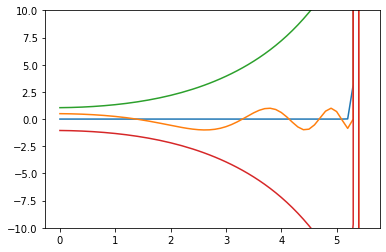

In [33]:
### plotting...
plt.plot(np.arange(1000)*0.1,traj[0:4].T)
plt.ylim(-10,10)

print('bleeh!:')
plt.show()#plotting...

In [ ]:
def animate(q_array,L1=1,L2=1,T=10):
    """
    Function to generate web-based animation of double-pendulum system

    Parameters:
    ================================================
    theta_array:
        trajectory of theta1 and theta2, should be a NumPy array with
        shape of (2,N)
    L1:
        length of the first pendulum
    L2:
        length of the second pendulum
    T:
        length/seconds of animation duration

    Returns: None
    """

    ################################
    # Imports required for animation.
    from plotly.offline import init_notebook_mode, iplot
    from IPython.display import display, HTML
    import plotly.graph_objects as go

    #######################
    # Browser configuration.
    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)

    ###############################################
    # Getting data from pendulum angle trajectories.
#     xx1=L1*np.sin(theta_array[0])
#     yy1=-L1*np.cos(theta_array[0])
#     xx2=xx1+L2*np.sin(theta_array[0]+theta_array[1])
#     yy2=yy1-L2*np.cos(theta_array[0]+theta_array[1])
    xxA = q_array[0] #TODO: WHAT DO I NEED THIS FOR?
    yyA = q_array[1]
    N = len(q_array[0]) # Need this for specifying length of simulation

    ###############################################
    # Define arrays containing data for frame axes
    # In each frame, the x and y axis are always fixed
    x_axis = np.array([0.3, 0.0])
    y_axis = np.array([0.0, 0.3])
    origin = np.array([0.0, 0.0])
    
    # Use homogeneous tranformation to transfer these two axes/points
    # back to the fixed frame
    frame_a_x_axis = np.zeros((2,N))
    frame_a_y_axis = np.zeros((2,N))
    frame_a_origin = np.zeros((2,N))
    
    frame_b_x_axis = np.zeros((2,N))
    frame_b_y_axis = np.zeros((2,N))
    frame_b_origin = np.zeros((2,N))
    
    frame_c_x_axis = np.zeros((2,N))
    frame_c_y_axis = np.zeros((2,N))
    frame_c_origin = np.zeros((2,N))
    
    frame_d_x_axis = np.zeros((2,N))
    frame_d_y_axis = np.zeros((2,N))
    frame_d_origin = np.zeros((2,N))
    
    frame_e_x_axis = np.zeros((2,N))
    frame_e_y_axis = np.zeros((2,N))
    frame_e_origin = np.zeros((2,N))
    
    for i in range(N): # iteration through each time step
        # evaluate homogeneous transformations
        t_wa = np.array([[1,0,q_array[0][i]],
                         [0,1,q_array[1][i]],
                         [0,0,1]])
        t_ab = np.array([[np.cos(q_array[2][i]), -np.sin(q_array[2][i]), (L1/2)*np.sin(q_array[2][i])],
                         [np.sin(q_array[2][i]),  np.cos(q_array[2][i]), -(L1/2)*np.cos(q_array[2][i])],
                         [                        0,                          0, 1]])
        t_bd = np.array([[1,0,0],
                         [0,1,-L1/2],
                         [0,0,1]])
        t_ac = np.array([[np.cos(q_array[3][i]), -np.sin(q_array[3][i]), (L2/2)*np.sin(q_array[3][i])],
                         [np.sin(q_array[3][i]),  np.cos(q_array[3][i]), -(L2/2)*np.cos(q_array[3][i])],
                         [                        0,                          0, 1]])
        t_ce = np.array([[1,0,0],
                         [0,1,-L2/2],
                         [0,0,1]])
        
        #multiplying to get specific frame transforms...
        t_wb = np.matmul(t_wa,t_ab)
        t_wc = np.matmul(t_wa,t_ac)
        t_wd = np.matmul(t_wb,t_bd)
        t_we = np.matmul(t_wc,t_ce)
        
        # transfer the x and y axes in body frame back to fixed frame at 
        # the current time step
        frame_a_x_axis[:,i] = t_wa.dot([x_axis[0], x_axis[1], 1])[0:2]
        frame_a_y_axis[:,i] = t_wa.dot([y_axis[0], y_axis[1], 1])[0:2]
        frame_a_origin[:,i] = t_wa.dot([origin[0], origin[1], 1])[0:2]
        
        frame_b_x_axis[:,i] = t_wb.dot([x_axis[0], x_axis[1], 1])[0:2]
        frame_b_y_axis[:,i] = t_wb.dot([y_axis[0], y_axis[1], 1])[0:2]
        frame_b_origin[:,i] = t_wb.dot([origin[0], origin[1], 1])[0:2]
        
        frame_c_x_axis[:,i] = t_wc.dot([x_axis[0], x_axis[1], 1])[0:2]
        frame_c_y_axis[:,i] = t_wc.dot([y_axis[0], y_axis[1], 1])[0:2]
        frame_c_origin[:,i] = t_wc.dot([origin[0], origin[1], 1])[0:2]
        
        frame_d_x_axis[:,i] = t_wd.dot([x_axis[0], x_axis[1], 1])[0:2]
        frame_d_y_axis[:,i] = t_wd.dot([y_axis[0], y_axis[1], 1])[0:2]
        frame_d_origin[:,i] = t_wd.dot([origin[0], origin[1], 1])[0:2]
        
        frame_e_x_axis[:,i] = t_we.dot([x_axis[0], x_axis[1], 1])[0:2]
        frame_e_y_axis[:,i] = t_we.dot([y_axis[0], y_axis[1], 1])[0:2]
        frame_e_origin[:,i] = t_we.dot([origin[0], origin[1], 1])[0:2]

    ####################################
    # Using these to specify axis limits.
    xm = -3 #np.min(xx1)-0.5
    xM = 3 #np.max(xx1)+0.5
    ym = -3 #np.min(yy1)-2.5
    yM = 3 #np.max(yy1)+1.5

    ###########################
    # Defining data dictionary.
    # Trajectories are here.
    data=[
        # note that except for the trajectory (which you don't need this time),
        # you don't need to define entries other than "name". The items defined
        # in this list will be related to the items defined in the "frames" list
        # later in the same order. Therefore, these entries can be considered as 
        # labels for the components in each animation frame
        dict(name='Arm'),
        dict(name='Mass 1'),
        dict(name='Mass 2'),
        dict(name='World Frame X'),
        dict(name='World Frame Y'),
        dict(name='A Frame X Axis'),
        dict(name='A Frame Y Axis'),
        dict(name='B Frame X Axis'),
        dict(name='B Frame Y Axis'),
        dict(name='C Frame X Axis'),
        dict(name='C Frame Y Axis'),
        dict(name='D Frame X Axis'),
        dict(name='D Frame Y Axis'),
        dict(name='E Frame X Axis'),
        dict(name='E Frame Y Axis'),

        # You don't need to show trajectory this time,
        # but if you want to show the whole trajectory in the animation (like what
        # you did in previous homeworks), you will need to define entries other than 
        # "name", such as "x", "y". and "mode".

        # dict(x=xx1, y=yy1, 
        #      mode='markers', name='Pendulum 1 Traj', 
        #      marker=dict(color="fuchsia", size=2)
        #     ),
        # dict(x=xx2, y=yy2, 
        #      mode='markers', name='Pendulum 2 Traj', 
        #      marker=dict(color="purple", size=2)
        #     ),
        ]

    ################################
    # Preparing simulation layout.
    # Title and axis ranges are here.
    layout=dict(autosize=False, width=1000, height=1000,
                xaxis=dict(range=[xm, xM], autorange=False, zeroline=True,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Double Pendulum Simulation', 
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                               'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                           {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                          ]
                              }]
               )

    ########################################
    # Defining the frames of the simulation.
    # This is what draws the lines from
    # joint to joint of the pendulum.
    frames=[dict(data=[# first three objects correspond to the arms and two masses,
                       # same order as in the "data" variable defined above (thus 
                       # they will be labeled in the same order)
#                        dict(x=[0,xx1[k],xx2[k]], 
#                             y=[0,yy1[k],yy2[k]], 
#                             mode='lines',
#                             line=dict(color='orange', width=3),
#                             ),
#                        go.Scatter(
#                             x=[xx1[k]],
#                             y=[yy1[k]],
#                             mode="markers",
#                             marker=dict(color="blue", size=12)),
#                        go.Scatter(
#                             x=[xx2[k]],
#                             y=[yy2[k]],
#                             mode="markers",
#                             marker=dict(color="blue", size=12)),
                       # display x and y axes of the fixed frame in each animation frame
                       dict(x=[0,x_axis[0]], 
                            y=[0,x_axis[1]], 
                            mode='lines',
                            line=dict(color='yellow', width=3),
                            ),
                       dict(x=[0,y_axis[0]], 
                            y=[0,y_axis[1]], 
                            mode='lines',
                            line=dict(color='yellow', width=3),
                            ),
                       # display x and y axes of the {A} frame in each animation frame
                       dict(x=[frame_a_origin[0][k], frame_a_x_axis[0][k]], 
                            y=[frame_a_origin[1][k], frame_a_x_axis[1][k]], 
                            mode='lines',
                            line=dict(color='green', width=3),
                            ),
                       dict(x=[frame_a_origin[0][k], frame_a_y_axis[0][k]], 
                            y=[frame_a_origin[1][k], frame_a_y_axis[1][k]],
                            mode='lines',
                            line=dict(color='red', width=3),
                            ),
                       dict(x=[frame_b_origin[0][k], frame_b_x_axis[0][k]], #frame b
                            y=[frame_b_origin[1][k], frame_b_x_axis[1][k]], 
                            mode='lines',
                            line=dict(color='green', width=3),
                            ),
                       dict(x=[frame_b_origin[0][k], frame_b_y_axis[0][k]], 
                            y=[frame_b_origin[1][k], frame_b_y_axis[1][k]],
                            mode='lines',
                            line=dict(color='red', width=3),
                            ),
                       dict(x=[frame_c_origin[0][k], frame_c_x_axis[0][k]], #frame c
                            y=[frame_c_origin[1][k], frame_c_x_axis[1][k]], 
                            mode='lines',
                            line=dict(color='green', width=3),
                            ),
                       dict(x=[frame_c_origin[0][k], frame_c_y_axis[0][k]], 
                            y=[frame_c_origin[1][k], frame_c_y_axis[1][k]],
                            mode='lines',
                            line=dict(color='red', width=3),
                            ),
                       dict(x=[frame_d_origin[0][k], frame_d_x_axis[0][k]], #frame d
                            y=[frame_d_origin[1][k], frame_d_x_axis[1][k]], 
                            mode='lines',
                            line=dict(color='green', width=3),
                            ),
                       dict(x=[frame_d_origin[0][k], frame_d_y_axis[0][k]], 
                            y=[frame_d_origin[1][k], frame_d_y_axis[1][k]],
                            mode='lines',
                            line=dict(color='red', width=3),
                            ),
                       dict(x=[frame_d_origin[0][k], frame_d_x_axis[0][k]], #frame d
                            y=[frame_d_origin[1][k], frame_d_x_axis[1][k]], 
                            mode='lines',
                            line=dict(color='green', width=3),
                            ),
                       dict(x=[frame_e_origin[0][k], frame_e_x_axis[0][k]], 
                            y=[frame_e_origin[1][k], frame_e_x_axis[1][k]],
                            mode='lines',
                            line=dict(color='red', width=3),
                            ),
                       dict(x=[frame_e_origin[0][k], frame_e_y_axis[0][k]], 
                            y=[frame_e_origin[1][k], frame_e_y_axis[1][k]],
                            mode='lines',
                            line=dict(color='green', width=3),
                            )
                        
                      ]) for k in range(N)]

    #######################################
    # Putting it all together and plotting.
    figure1=dict(data=data, layout=layout, frames=frames)           
    iplot(figure1)

In [ ]:
animate(traj[0:4],L1=1,L2=1,T=10)